1) Вывод по первому пункту: Данные содержал русские слова, цифры, спец.символы, ссылки, телефоны, смайлики. Однозначно имеет смысл удалить смайлики и символы переноса (/n), с другим надо проверять. Данные представляют собой скорее какие-то объявления.
2) Не получилось запустить вариант с w2v, поскольку потребуется откат нескольких пакетов, что вызывало ошибки в уже написанной части кода (надо было не оставлять на потом и писать на предыдущей версии питона, сам виноват)
3) Не получилось сгенерировать данные с помощью "ai-forever/rugpt3medium_based_on_gpt2", надо будет потом попробовать еще раз
4) Лучший результат получился с помощью аугментации данных (через синонимайзер), регуляризации r"""[^a-zA-Zа-яА-Я0-9\s@=+%&'"!#?,.:;\/-]""", обычной whitespace токенизации, лемматизации pymorphy, модель "ai-forever/ruBert-large" (конкретно тут она недообучена, но
это для экономии времени при сборе файла)

In [1]:
import os
from collections import defaultdict
import re
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pymorphy2
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
import nlpaug.augmenter.word as naw
from nlpaug.augmenter.word import SynonymAug, ContextualWordEmbsAug
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset, 
                            random_split, ConcatDataset)
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import (LinearLR, ReduceLROnPlateau, 
                                     SequentialLR, CosineAnnealingLR)
from transformers import (AutoTokenizer, 
                         AutoModelForSequenceClassification,
                         get_linear_schedule_with_warmup)
import copy
from collections import Counter
from IPython.display import display

/home/n03rrz/anaconda3/envs/dl_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

Using cuda


### EDA

,text,labels
id,,
0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
5,Мультимедийный концерт «От аниме до k-pop»\nОр...,1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0
6,Космическое место в Зарядье\n📸\ndujarden\n#афи...,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1
7,20 апреля\nМероприятия Ко Дню национального ко...,0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
8,"""Подыскиваю жену. Недорого!""\n🏛\nДворец культу...",1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0


Index(['text', 'labels'], dtype='object')

labels
1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0    1053
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0     742
0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0     727
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     510
0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     477
                                           ... 
1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0       1
1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0       1
0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0       1
1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0       1
0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0       1
Name: count, Length: 3540, dtype: int64

id
0        39
1        39
2        39
3        39
4        39
         ..
29563    39
29564    39
29565    39
29566    39
29567    39
Name: labels, Length: 29568, dtype: int64

,text,labels,tweet_length,word_count
id,,,,
0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,121,16
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,70,9
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,69,11
3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,635,94
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,732,102
5,Мультимедийный концерт «От аниме до k-pop»\nОр...,1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0,472,60
6,Космическое место в Зарядье\n📸\ndujarden\n#афи...,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1,165,21
7,20 апреля\nМероприятия Ко Дню национального ко...,0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,123,18
8,"""Подыскиваю жену. Недорого!""\n🏛\nДворец культу...",1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,881,138


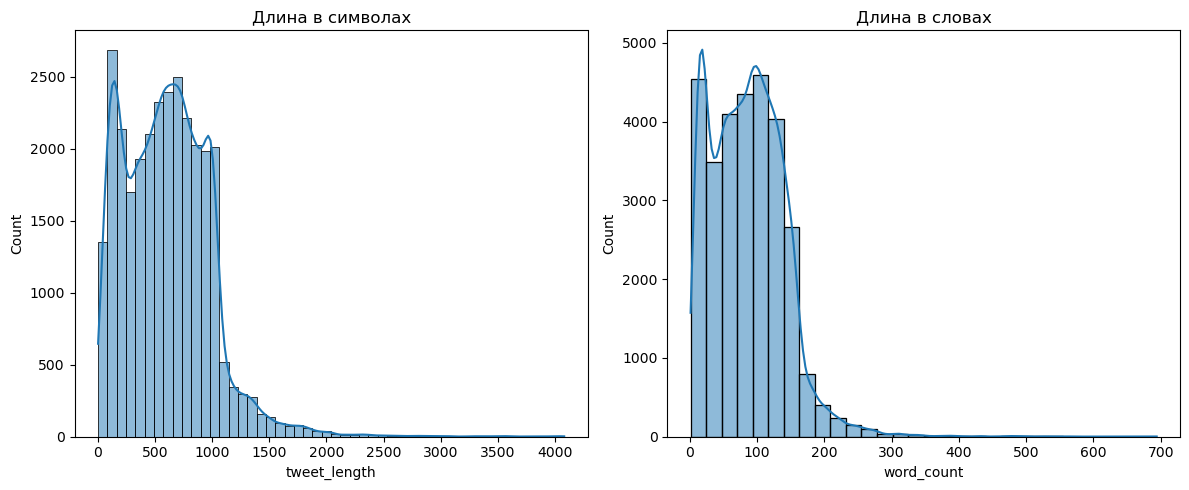

,text,labels
id,,
0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


'15 января\nДетская развлекательная программа\n15-00 бесплатно\n❗️\n@\ncafeotdyh\nКафе "Отдых"\n📍\nЗапись обязательно +73472228532'

'13 и 14 августа\nВыходные в Меге\nhttps://t.me/megaufa_official\nМегапарк'

'Йокнапатофа\nПостановка Театр им. Маяковского\nБилеты от 500 до 2000 р.'

'Впервые в Уфе танцевальная терапия в группе с практикующим психологом\nТема встречи: «Отношения. Доверие. Контакт»\nПриходите, если:\n🔸\nвы хотите наладить или поисследовать свои отношения с\n-\xa0 телом\n- собой\n- близким человеком\n- работой\n- деньгами\n🔸\nне можете разрешить или забыть какую-то\xa0 ситуацию, связанную с отношениями\n🔸\nне умеете доверять или делегировать\n🔸\nтяжело вступаете в контакт\nЗадать вопрос психологу курса\nи записаться можно здесь:\n@LeontevaKsenia\nДата\n: 26 января\nВремя\n: 19.00-21.00\nАдрес\n: Коммунистическая, 45/3, Б/ц "Деловой двор"\nСтоимость: 1500\nЧто нужно для занятия:\nудобная одежда, носки, вода, желание танцевать.'

'🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня открытие IV Международного конкурса GRAND PIANO (для пианистов до 16 лет) в зале Чайковского.\nСегодня прозвучит премьера концерта АЛЕКСАНДРА ЧАЙКОВСКОГО для 4 (!!!!) роялей!!!\nВместе с ДЕНИСОМ МАЦУЕВЫМ (которому и посвящён этот концерт)\nбудут играть лауреаты прошлых лет:\nПЁТР АКУЛОВ,\nИВАН БЕССОНОВ и СЕРГЕЙ ДАВЫДЧЕНКО (победитель прошедшего конкурса Чайковского, где председателем комиссии был МАЦУЕВ)\nАккомпанировать солистам будет ГОСОРКЕСТР России имени Е. Ф. СВЕТЛАНОВА под управлением АЛЕКСАНДРА СЛАДКОВСКОГО.\nРасписание конкурса можно посмотреть\nздесь\n.\nНаграждение и закрытие конкурса будет 18 июня.\nКапелька билетов ещё есть по 12 000 в первых рядах на\nсайте конкурса\n.\n#конкурсы'

'Мультимедийный концерт «От аниме до k-pop»\nОркестр Nella Musica Orchestra предлагает уникальное музыкальное путешествие, где прозвучат саундтреки из популярных аниме, таких как «Магическая битва», «Атака Титанов» и «Ходячий замок», а также знаменитые K-pop хиты. Музыкальные темы в сопровождении видеоарта погрузят в атмосферу любимых аниме-историй и современных музыкальных трендов.\nКогда: 1 сентября, 21:00. Вход свободный.\nГде: Парк Зарядье, Большой амфитеатр\n#концерты'

'Космическое место в Зарядье\n📸\ndujarden\n#афиша #афиша_москвы #мероприятия #выставки #фестивали #концерты #спектакли #музеи #парки\n✅\nПодпишись на наш канал\n@gomosevent'

'20 апреля\nМероприятия Ко Дню национального костюма: день в стиле Этна\nс 11-00 до 15-00\nhttps://vk.com/museumrb\nСоветская 14'

'"Подыскиваю жену. Недорого!"\n🏛\nДворец культуры железнодорожников\n🗓\n06.01 (сб) в 16:00\n🎫\nБилеты по ссылке здесь\n💚\n-25% по промокоду TIK\nВ ролях: Екатерина Скулкина/Надежда Ангарская, Мария Кравченко/Татьяна Морозова, Роман Юнусов/Роман Богданов и др\nСделать правильный выбор в браке – это одна из главных задач в жизни Игоря, осечки быть не должно и для этого он готов устраивать для претенденток самые невероятные испытания. А побороться есть за что: он и успешен и богат, но только он не спешит раскрывать все карты. Успешного и богатого полюбит любая, а вот кто полюбит мелкого служащего с низким окладом и скромной однокомнатной квартирой, в которой, кстати, все и происходит. Игорю кажется что правильный выбор сделан, но жизнь преподносит сюрпризы: люди оказываются совсем не теми, за кого себя выдают, и счастье было рядом, но не было замечено…\n🥰\nБилеты со скидками\n@teatrspb'

'Концерт «Мамульки Бенд» - электронный сгусток музыкальных пародий на песни повышенной святости (16+)\n🏛\nКлуб-ресторан Петрович\n📍\nМясницкая 24/7, стр 3\n🗓\n31 октября 19:00\n🎫\nБилеты по ссылке здесь\n💚\n-20% по промокоду ТАНЦЫ\n«Мамульки Bend» - этот эклектичный и харизматичный коллектив из Ярославля завоевал сердца поклонников по всей стране своей задорной, энергичной и бесконечно танцевальной музыкой. На их концертах только атмосфера чистой радости и веселья.\nЕсли вы ищете, где зарядиться адреналином и улыбкой на всю неделю, то этот концерт – ваш выбор! Будет так весело, что даже ваш внутренний скептик пустится в пляс. «Мамульки Bend» обещают показать шоу, от которого у вас останется не только улыбка, но и желание кричать "Браво!" до хрипоты.\nПриходите! Будет громко, весело и незабываемо – гарантируем!\n🥰\nБилеты со скидками\n#афиша #афиша_москвы #мероприятия #выставки #фестивали #концерты #спектакли #постановки #театр #билеты #шоу #экскурсии #музеи #парки\n✅\nПодпишись на наш 

In [4]:
train = pd.read_csv("train.csv", index_col='id')
display(train.head(10))
display(train.columns)
display(train["labels"].value_counts())
display(train["labels"].apply(len))

train["tweet_length"] = train["text"].apply(len)

train["word_count"] = train["text"].apply(lambda x: len(x.split()))
display(train.head(10))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x="tweet_length", bins=50, kde=True)
plt.title("Длина в символах")
plt.subplot(1, 2, 2)
sns.histplot(data=train, x="word_count", bins=30, kde=True)
plt.title("Длина в словах")
plt.tight_layout()
plt.show()

train.drop(columns=["tweet_length", "word_count"], inplace=True)
display(train.head(5))

for i in range(10):
    display(train["text"][i])

### Filter & tokenize

In [4]:
train = pd.read_csv("train.csv", index_col='id')

def regular_cleaning(text):
    text = re.sub(r"""[^a-zA-Zа-яА-Я0-9\s@=+%&'"!#?,.:;\/-]""", "", text, flags=re.IGNORECASE).lower()
    return text

train["no_trash"] = train["text"].apply(regular_cleaning)
def tokenize(text):
    tk = WhitespaceTokenizer() 
    tokenize_result = tk.tokenize(text)
    return tokenize_result

train_clean = train["text"].apply(regular_cleaning)

### Lemmatization

In [5]:
train["labels"] = train["labels"].str.replace(" ", "")
display(train.head(5))

labels_array = np.array([list(map(int, list(label))) for label in train["labels"]])

texts_prep = train["no_trash"]


train_df, test_df, train_labels, val_labels = train_test_split(
    texts_prep, labels_array, 
    test_size=0.2, 
    random_state=52
)

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec

morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text(text, method='lemmatize'):
    tokens = tokenize(text)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return " ".join(tokens)

tqdm.pandas()
train_df['processed_text'] = train_df.progress_apply(lambda x: preprocess_text(x, method='lemmatize'))
test_df['processed_text'] = test_df.progress_apply(lambda x: preprocess_text(x, method='lemmatize'))

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

def safe_augment(text, aug_p=0.3):
    try:
        aug = ContextualWordEmbsAug(
            model_path='cointegrated/rubert-tiny',
            action="substitute",
            aug_p=aug_p,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        return aug.augment(text)
    except Exception as e:
        print(f"Ошибка аугментации: {e}")
        return text

def enrich_dataset(text_series, labels, aug_percent=0.2):
    num_samples = len(text_series)
    num_augments = int(num_samples * aug_percent)
    
    aug_indices = np.random.choice(num_samples, num_augments, replace=False)
    
    augmented_texts = []
    augmented_labels = []

    augmented_texts.extend(text_series.tolist())
    augmented_labels.extend(labels)

    for idx in tqdm(aug_indices, desc="Аугментация данных"):
        text = text_series.iloc[idx]
        label = labels[idx]
        
        aug_text = safe_augment(text)

        if isinstance(aug_text, list):
            aug_text = ' '.join(aug_text)
        elif not isinstance(aug_text, str):
            aug_text = str(aug_text)
        
        if aug_text != text:
            augmented_texts.append(aug_text)
            augmented_labels.append(label)

    train_enriched = pd.Series(augmented_texts, name='processed_text')
    train_labels_enriched = np.array(augmented_labels)
    
    return train_enriched, train_labels_enriched

train_enriched, train_labels_enriched = enrich_dataset(
    train_df['processed_text'],
    train_labels,
    aug_percent=0.2
)

,text,labels,no_trash
id,,,
0,15 января\nДетская развлекательная программа\n...,10001000100011111001,15 января\nдетская развлекательная программа\n...
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,00010000100011011001,13 и 14 августа\nвыходные в меге\nhttps://t.me...
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,00001000000011011001,йокнапатофа\nпостановка театр им. маяковского\...
3,Впервые в Уфе танцевальная терапия в группе с ...,11001001111111100110,впервые в уфе танцевальная терапия в группе с ...
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",11000001100111101110,"\ngrand piano competition\n\nдрузья, сегодня о..."


[nltk_data] Downloading package stopwords to /home/n03rrz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 5914/5914 [00:27<00:00, 213.40it/s]
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/n03rrz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/n03rrz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/n03rrz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Аугментация данных: 100%|██████████| 4730/4730 [01:29<00:00, 52.59it/s]


In [27]:
# from natasha import Doc, MorphVocab

In [28]:
# def lemmatization(text):
#     doc = Doc(text)
#     doc.segment(segmenter=None)
#     doc.tag_morph(morph_vocab)
#     lemmas = [token.lemma for token in doc.tokens]
#     # morph_vocab = MorphVocab()
#     # text.lemmatize(morph_vocab)
#     return lemmas

# lemmas = train["no_trash"].apply(lemmatization)

In [30]:
# from natasha import (
#     MorphVocab,
#     Doc,
#     Segmenter,
#     NewsEmbedding,
#     NewsMorphTagger
# )

In [47]:
# test_tr = train.iloc[:200].copy()

In [58]:
# segmenter = Segmenter()
# morph_vocab = MorphVocab()
# emb = NewsEmbedding()
# morph_tagger = NewsMorphTagger(emb)

# def lemmatize_text(text):
#     doc = Doc(text)
#     doc.segment(segmenter)
#     doc.tag_morph(morph_tagger)
#     return [token.lemma for token in doc.tokens]

# test_tr['lemmas'] = test_tr['no_trash'].astype(str).apply(lemmatize_text)

In [59]:
# display(test_tr["lemmas"])

id
0      [None, None, None, None, None, None, None, Non...
1      [None, None, None, None, None, None, None, Non...
2      [None, None, None, None, None, None, None, Non...
3      [None, None, None, None, None, None, None, Non...
4      [None, None, None, None, None, None, None, Non...
                             ...                        
195    [None, None, None, None, None, None, None, Non...
196    [None, None, None, None, None, None, None, Non...
197    [None, None, None, None, None, None, None, Non...
198    [None, None, None, None, None, None, None, Non...
199    [None, None, None, None, None, None, None, Non...
Name: lemmas, Length: 200, dtype: object

In [ ]:
# # Вариант для уже токенизированного текста (если нужно)
# def lemmatize_tokens(tokens):
#     doc = Doc(' '.join(tokens))
#     doc.segment(segmenter)
#     doc.tag_morph(morph_tagger)
#     return [token.lemma for token in doc.tokens]

# train['lemmas'] = train['all_tokenized'].apply(lemmatize_tokens)

# # Подготовка для TF-IDF
# train['lemmas_text'] = train['lemmas'].apply(' '.join)

# # Создание TF-IDF векторов
# vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), token_pattern=None)
# X_tfidf = vectorizer.fit_transform(train['lemmas_text'])

# # Создание Word2Vec модели
# w2v_model = Word2Vec(
#     sentences=train['lemmas'],
#     vector_size=100,
#     window=5,
#     min_count=3,
#     workers=4
# )

In [37]:
# train["no_trash"].astype(str)[1]

'13 и 14 августа выходные в меге https://t.me/megaufaofficial мегапарк'

In [61]:
# morph_vocab = MorphVocab()

# def lemmatize_text(text):
#     doc = Doc(text)
#     doc.segment(segmenter)  # Отключаем сегментацию предложений
#     doc.tag_morph(morph_vocab)   # Морфологический разбор
#     return [token.lemma for token in doc.tokens]

# # Применяем к колонке no_trash
# test_tr['lemmas'] = test_tr['no_trash'].astype(str).apply(lemmatize_text)

AttributeError: 'MorphVocab' object has no attribute 'map'

### Немножко простейшая модель для tf-idf

Количество фичей: 50000
Using device: cuda
Epoch 01
Train Loss: 0.2842 | Val Loss: 0.2142
Train Acc: 0.1264 | Val Acc: 0.2142
Train F1: 0.8769 | Val F1: 0.9091
LR: 1.00e-03

Epoch 02
Train Loss: 0.1815 | Val Loss: 0.1967
Train Acc: 0.2617 | Val Acc: 0.2484
Train F1: 0.9246 | Val F1: 0.9148
LR: 1.00e-03

Epoch 03
Train Loss: 0.1380 | Val Loss: 0.1957
Train Acc: 0.3650 | Val Acc: 0.2731
Train F1: 0.9442 | Val F1: 0.9193
LR: 1.00e-03

Epoch 04
Train Loss: 0.1137 | Val Loss: 0.2028
Train Acc: 0.4405 | Val Acc: 0.2832
Train F1: 0.9553 | Val F1: 0.9193
LR: 1.00e-03

Epoch 05
Train Loss: 0.0967 | Val Loss: 0.2104
Train Acc: 0.5029 | Val Acc: 0.2854
Train F1: 0.9625 | Val F1: 0.9197
LR: 1.00e-03

Epoch 06
Train Loss: 0.0866 | Val Loss: 0.2180
Train Acc: 0.5406 | Val Acc: 0.2890
Train F1: 0.9667 | Val F1: 0.9200
LR: 1.00e-03

Epoch 07
Train Loss: 0.0772 | Val Loss: 0.2253
Train Acc: 0.5787 | Val Acc: 0.2957
Train F1: 0.9707 | Val F1: 0.9200
LR: 1.00e-03

Epoch 08
Train Loss: 0.0720 | Val Loss: 

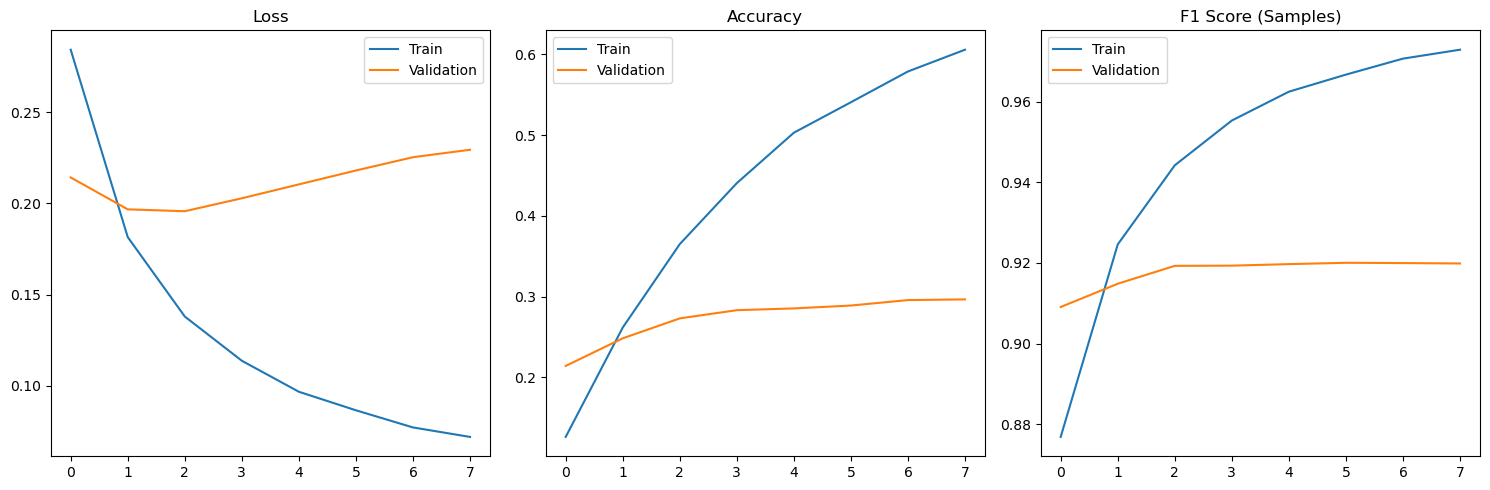


Final Validation Report:
Sample-based Accuracy: 0.2890
Sample-based F1 Score: 0.9200


In [9]:
vectorizer = TfidfVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_df['processed_text']).toarray()
x_val = vectorizer.transform(test_df['processed_text'])
num_features = len(vectorizer.get_feature_names_out())
print(f"Количество фичей: {num_features}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(train_labels).to(device)
X_val_tensor = torch.FloatTensor(x_val.toarray()).to(device)
y_val_tensor = torch.FloatTensor(val_labels).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        return self.fc3(x)

model = MultiLabelClassifier(
    input_dim=X_train.shape[1], 
    num_classes=20
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.001)

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

def calculate_metrics(outputs, labels, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='samples')
    return acc, f1

def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        acc, f1 = calculate_metrics(outputs, labels)
        total_acc += acc * inputs.size(0)
        total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

def validate_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            acc, f1 = calculate_metrics(outputs, labels)
            total_acc += acc * inputs.size(0)
            total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

best_f1 = 0.0
best_model = None

for epoch in range(10):
    train_metrics = train_epoch(model, train_loader, optimizer)
    
    val_metrics = validate_epoch(model, val_loader)
    
    for key in history:
        history[key].append(train_metrics[key[6:]] if 'train' in key else val_metrics[key[4:]])
    
    scheduler.step(val_metrics['f1'])
    early_stopping(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, 'best_multi_label_model.pth')
    
    print(f"Epoch {epoch+1:02d}")
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(f"Train Acc: {train_metrics['acc']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
    print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

model.load_state_dict(torch.load('best_multi_label_model.pth'))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score (Samples)')
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_probs = torch.sigmoid(val_outputs)
    val_preds = (val_probs > 0.5).float()

print("\nFinal Validation Report:")
print(f"Sample-based Accuracy: {accuracy_score(y_val_tensor.cpu().numpy(), val_preds.cpu().numpy()):.4f}")
print(f"Sample-based F1 Score: {f1_score(y_val_tensor.cpu().numpy(), val_preds.cpu().numpy(), average='samples'):.4f}")

### W2V

In [ ]:
# sentences = [text.split() for text in train_df['processed_text']]

# w2v_model = Word2Vec(
#     sentences=sentences,
#     vector_size=300,
#     window=5,
#     min_count=3,
#     workers=4,
#     sg=1,
#     epochs=10
# )

# def text_to_vector(text):
#     words = text.split()
#     word_vectors = []
#     for word in words:
#         if word in w2v_model.wv:
#             word_vectors.append(w2v_model.wv[word])
#     if len(word_vectors) > 0:
#         return np.mean(word_vectors, axis=0)
#     else:
#         return np.zeros(w2v_model.vector_size)

# X_train_w2v = np.array([text_to_vector(text) for text in tqdm(train_df['processed_text'])])
# X_val_w2v = np.array([text_to_vector(text) for text in tqdm(test_df['processed_text'])])

# X_train_tensor = torch.FloatTensor(X_train_w2v).to(device)
# X_val_tensor = torch.FloatTensor(X_val_w2v).to(device)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# X_train_tensor = torch.FloatTensor(X_train).to(device)
# y_train_tensor = torch.FloatTensor(train_labels).to(device)
# X_val_tensor = torch.FloatTensor(x_val.toarray()).to(device)
# y_val_tensor = torch.FloatTensor(val_labels).to(device)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# class W2VClassifier(nn.Module):
#     def __init__(self, input_dim=300, num_classes):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 512)
#         self.bn1 = nn.BatchNorm1d(512)
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 256)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.dropout2 = nn.Dropout(0.3)
#         self.fc3 = nn.Linear(256, num_classes)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = nn.ReLU()(x)
#         x = self.dropout1(x)
        
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = nn.ReLU()(x)
#         x = self.dropout2(x)
        
#         return self.fc3(x)

# model = W2VClassifier(input_dim=w2v_model.vector_size, num_classes=20).to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

# class EarlyStopping:
#     def __init__(self, patience=5, delta=0):
#         self.patience = patience
#         self.delta = delta
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False

#     def __call__(self, val_score):
#         if self.best_score is None:
#             self.best_score = val_score
#         elif val_score < self.best_score + self.delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = val_score
#             self.counter = 0

# early_stopping = EarlyStopping(patience=5, delta=0.001)

# history = {
#     'train_loss': [], 'val_loss': [],
#     'train_acc': [], 'val_acc': [],
#     'train_f1': [], 'val_f1': []
# }

# def calculate_metrics(outputs, labels, threshold=0.5):
#     probs = torch.sigmoid(outputs)
#     preds = (probs > threshold).float()
    
#     acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
#     f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='samples')
#     return acc, f1

# def train_epoch(model, loader, optimizer):
#     model.train()
#     running_loss = 0.0
#     total_acc, total_f1 = 0.0, 0.0
    
#     for inputs, labels in loader:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         acc, f1 = calculate_metrics(outputs, labels)
#         total_acc += acc * inputs.size(0)
#         total_f1 += f1 * inputs.size(0)
    
#     return {
#         'loss': running_loss / len(loader),
#         'acc': total_acc / len(loader.dataset),
#         'f1': total_f1 / len(loader.dataset)
#     }

# def validate_epoch(model, loader):
#     model.eval()
#     running_loss = 0.0
#     total_acc, total_f1 = 0.0, 0.0
    
#     with torch.no_grad():
#         for inputs, labels in loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             running_loss += loss.item()
#             acc, f1 = calculate_metrics(outputs, labels)
#             total_acc += acc * inputs.size(0)
#             total_f1 += f1 * inputs.size(0)
    
#     return {
#         'loss': running_loss / len(loader),
#         'acc': total_acc / len(loader.dataset),
#         'f1': total_f1 / len(loader.dataset)
#     }

# best_f1 = 0.0
# best_model = None

# for epoch in range(100):
#     train_metrics = train_epoch(model, train_loader, optimizer)
    
#     val_metrics = validate_epoch(model, val_loader)
    
#     for key in history:
#         history[key].append(train_metrics[key[6:]] if 'train' in key else val_metrics[key[4:]])
    
#     scheduler.step(val_metrics['f1'])
#     early_stopping(val_metrics['f1'])
    
#     if val_metrics['f1'] > best_f1:
#         best_f1 = val_metrics['f1']
#         best_model = copy.deepcopy(model.state_dict())
#         torch.save(best_model, 'w2v.pth')
    
#     print(f"Epoch {epoch+1:02d}")
#     print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
#     print(f"Train Acc: {train_metrics['acc']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
#     print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
#     print(f"LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
#     if early_stopping.early_stop:
#         print("Early stopping triggered!")
#         break

# model.load_state_dict(torch.load('w2v.pth'))

# plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.plot(history['train_loss'], label='Train')
# plt.plot(history['val_loss'], label='Validation')
# plt.title('Loss')
# plt.legend()

# plt.subplot(132)
# plt.plot(history['train_acc'], label='Train')
# plt.plot(history['val_acc'], label='Validation')
# plt.title('Accuracy')
# plt.legend()

# plt.subplot(133)
# plt.plot(history['train_f1'], label='Train')
# plt.plot(history['val_f1'], label='Validation')
# plt.title('F1 Score (Samples)')
# plt.legend()

# plt.tight_layout()
# plt.show()

# model.eval()
# with torch.no_grad():
#     val_outputs = model(X_val_tensor)
#     val_probs = torch.sigmoid(val_outputs)
#     val_preds = (val_probs > 0.5).float()

# print("\nFinal Validation Report:")
# print(f"Sample-based Accuracy: {accuracy_score(y_val_tensor.cpu().numpy(), val_preds.cpu().numpy()):.4f}")
# print(f"Sample-based F1 Score: {f1_score(y_val_tensor.cpu().numpy(), val_preds.cpu().numpy(), average='samples'):.4f}")

### CNN

Epoch 01
Train Loss: 0.3681 | Val Loss: 0.2769
Train Acc: 0.0639 | Val Acc: 0.1192
Train F1: 0.8356 | Val F1: 0.8833
LR: 1.00e-03

Epoch 02
Train Loss: 0.2893 | Val Loss: 0.2494
Train Acc: 0.1067 | Val Acc: 0.1566
Train F1: 0.8748 | Val F1: 0.8944
LR: 1.00e-03

Epoch 03
Train Loss: 0.2600 | Val Loss: 0.2369
Train Acc: 0.1307 | Val Acc: 0.1733
Train F1: 0.8880 | Val F1: 0.9003
LR: 1.00e-03

Epoch 04
Train Loss: 0.2400 | Val Loss: 0.2287
Train Acc: 0.1538 | Val Acc: 0.1872
Train F1: 0.8978 | Val F1: 0.9027
LR: 1.00e-03

Epoch 05
Train Loss: 0.2211 | Val Loss: 0.2224
Train Acc: 0.1772 | Val Acc: 0.2032
Train F1: 0.9063 | Val F1: 0.9058
LR: 1.00e-03

Epoch 06
Train Loss: 0.2054 | Val Loss: 0.2187
Train Acc: 0.2030 | Val Acc: 0.2269
Train F1: 0.9138 | Val F1: 0.9086
LR: 1.00e-03

Epoch 07
Train Loss: 0.1916 | Val Loss: 0.2167
Train Acc: 0.2257 | Val Acc: 0.2284
Train F1: 0.9198 | Val F1: 0.9077
LR: 1.00e-03

Epoch 08
Train Loss: 0.1787 | Val Loss: 0.2185
Train Acc: 0.2456 | Val Acc: 0.2410


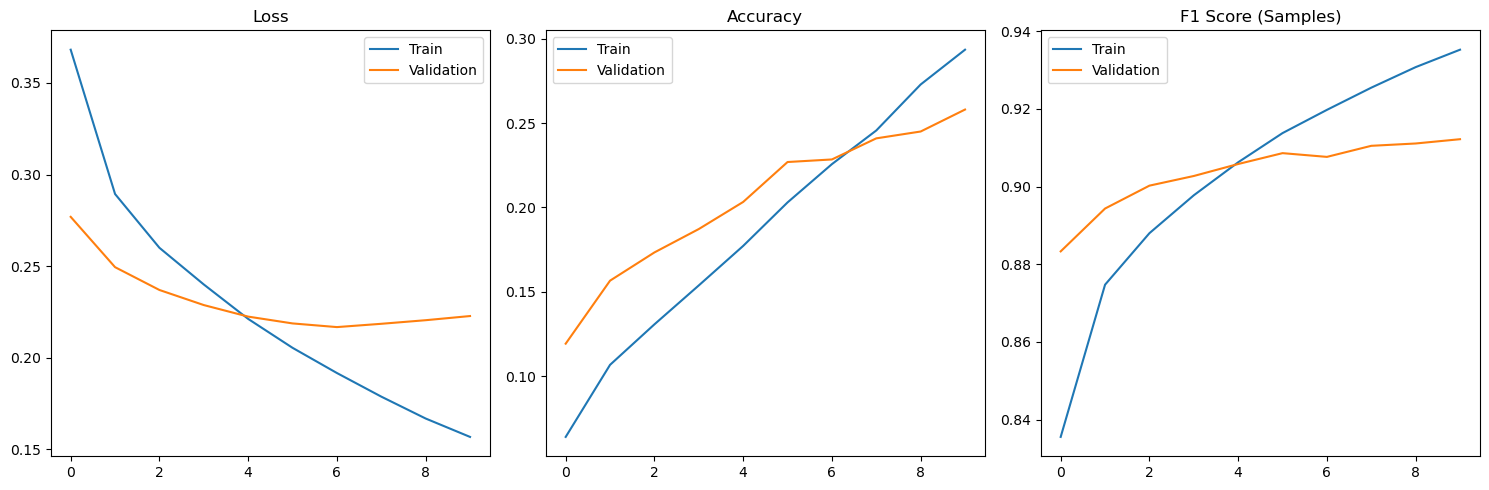

In [12]:
def build_vocab(texts, max_vocab_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<pad>': 0, '<unk>': 1}
    vocab.update({word: i+2 for i, (word, _) in enumerate(counter.most_common(max_vocab_size-2))})
    return vocab

vocab = build_vocab(train_df['processed_text'])
vocab_size = len(vocab)

def text_to_seq(text, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in text.split()]

train_sequences = [text_to_seq(text, vocab) for text in train_df['processed_text']]
val_sequences = [text_to_seq(text, vocab) for text in test_df['processed_text']]

max_len = 256
train_padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in train_sequences], 
                           batch_first=True, padding_value=0)
val_padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in val_sequences], 
                         batch_first=True, padding_value=0)

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_labels_tensor = torch.FloatTensor(train_labels)
val_labels_tensor = torch.FloatTensor(val_labels)

train_dataset = TextDataset(train_padded, train_labels_tensor)
val_dataset = TextDataset(val_padded, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, num_classes=20, num_filters=100, 
                 filter_sizes=[3, 4, 5], dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, 
                      out_channels=num_filters, 
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

model_CNN = TextCNN(
    vocab_size=vocab_size,
    embed_dim=300,
    num_classes=20,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.001)

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

def calculate_metrics(outputs, labels, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='samples')
    return acc, f1

def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        acc, f1 = calculate_metrics(outputs, labels)
        total_acc += acc * inputs.size(0)
        total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

def validate_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            acc, f1 = calculate_metrics(outputs, labels)
            total_acc += acc * inputs.size(0)
            total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

best_f1 = 0.0
best_model = None

for epoch in range(10):
    train_metrics = train_epoch(model_CNN, train_loader, optimizer)
    
    val_metrics = validate_epoch(model_CNN, val_loader)
    
    for key in history:
        history[key].append(train_metrics[key[6:]] if 'train' in key else val_metrics[key[4:]])
    
    scheduler.step(val_metrics['f1'])
    early_stopping(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model = copy.deepcopy(model_CNN.state_dict())
        torch.save(best_model, 'cnn.pth')
    
    print(f"Epoch {epoch+1:02d}")
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(f"Train Acc: {train_metrics['acc']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
    print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

model_CNN.load_state_dict(torch.load('cnn.pth'))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score (Samples)')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
kaggle = pd.read_csv("test.csv", index_col='id')

kaggle["no_trash"] = kaggle["text"].apply(regular_cleaning)
kaggle['processed_text'] = kaggle['no_trash'].progress_apply(
    lambda x: preprocess_text(x, method='lemmatize')
)

kaggle_sequences = [text_to_seq(text, vocab) for text in kaggle['processed_text']]
kaggle_padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in kaggle_sequences], 
                           batch_first=True, padding_value=0)

kaggle_dataset = TextDataset(kaggle_padded, torch.zeros(len(kaggle)))
kaggle_loader = DataLoader(kaggle_dataset, batch_size=128, shuffle=False)

model_CNN = TextCNN(
    vocab_size=vocab_size,
    embed_dim=300,
    num_classes=20,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)
model_CNN.load_state_dict(torch.load('cnn.pth'))
model_CNN.eval()

all_preds = []
with torch.no_grad():
    for inputs, _ in kaggle_loader:
        outputs = model_CNN(inputs.to(device))
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.append(preds)

test_preds = np.concatenate(all_preds)

kaggle['labels'] = [' '.join(map(str, pred)) for pred in test_preds]

kaggle[['labels']].to_csv("kaggle_predictions_cnn.csv")

100%|██████████| 7392/7392 [00:35<00:00, 210.35it/s]


### RNN

Epoch 01
Train Loss: 0.5021 | Val Loss: 0.4904
Train Acc: 0.0114 | Val Acc: 0.0091
Train F1: 0.7770 | Val F1: 0.7793
LR: 1.00e-03

Epoch 02
Train Loss: 0.4962 | Val Loss: 0.4897
Train Acc: 0.0109 | Val Acc: 0.0086
Train F1: 0.7806 | Val F1: 0.7900
LR: 1.00e-03

Epoch 03
Train Loss: 0.4956 | Val Loss: 0.4904
Train Acc: 0.0109 | Val Acc: 0.0090
Train F1: 0.7808 | Val F1: 0.7901
LR: 1.00e-03

Epoch 04
Train Loss: 0.4955 | Val Loss: 0.4893
Train Acc: 0.0105 | Val Acc: 0.0118
Train F1: 0.7817 | Val F1: 0.7792
LR: 1.00e-03

Epoch 05
Train Loss: 0.4952 | Val Loss: 0.4899
Train Acc: 0.0108 | Val Acc: 0.0088
Train F1: 0.7820 | Val F1: 0.7902
LR: 1.00e-03

Epoch 06
Train Loss: 0.4958 | Val Loss: 0.4763
Train Acc: 0.0109 | Val Acc: 0.0147
Train F1: 0.7812 | Val F1: 0.8038
LR: 1.00e-03

Epoch 07
Train Loss: 0.4737 | Val Loss: 0.3791
Train Acc: 0.0133 | Val Acc: 0.0267
Train F1: 0.7867 | Val F1: 0.8103
LR: 1.00e-03

Epoch 08
Train Loss: 0.3444 | Val Loss: 0.3270
Train Acc: 0.0413 | Val Acc: 0.0490


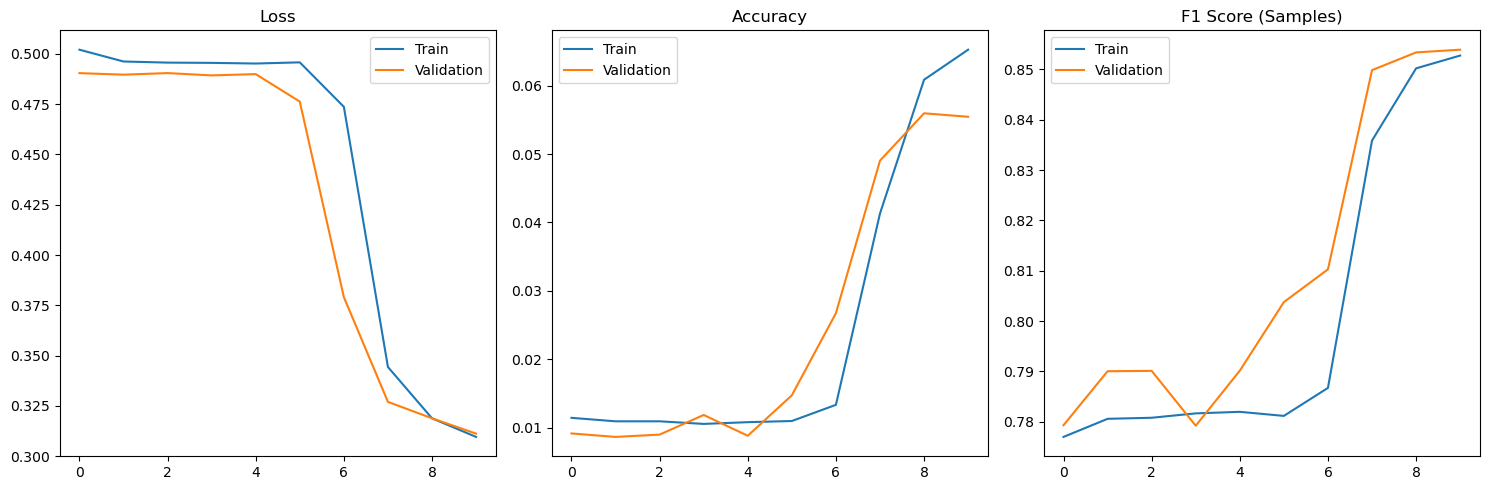

In [14]:
def build_vocab(texts, max_vocab_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<pad>': 0, '<unk>': 1}
    vocab.update({word: i+2 for i, (word, _) in enumerate(counter.most_common(max_vocab_size-2))})
    return vocab

vocab = build_vocab(train_df['processed_text'])
vocab_size = len(vocab)

def text_to_seq(text, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in text.split()]

train_sequences = [text_to_seq(text, vocab) for text in train_df['processed_text']]
val_sequences = [text_to_seq(text, vocab) for text in test_df['processed_text']]

max_len = 256  
train_padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in train_sequences], 
                          batch_first=True, padding_value=0)
val_padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in val_sequences], 
                        batch_first=True, padding_value=0)

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_labels_tensor = torch.FloatTensor(train_labels)
val_labels_tensor = torch.FloatTensor(val_labels)

train_dataset = TextDataset(train_padded, train_labels_tensor)
val_dataset = TextDataset(val_padded, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=256, num_layers=2, 
                 num_classes=20, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        lstm_out, _ = self.lstm(embedded)
        
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

model_LSTM = TextLSTM(
    vocab_size=vocab_size,
    embed_dim=300,
    hidden_dim=256,
    num_layers=2,
    num_classes=20,
    dropout=0.5
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_LSTM.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.001)

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

def calculate_metrics(outputs, labels, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='samples')
    return acc, f1

def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        acc, f1 = calculate_metrics(outputs, labels)
        total_acc += acc * inputs.size(0)
        total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

def validate_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    total_acc, total_f1 = 0.0, 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            acc, f1 = calculate_metrics(outputs, labels)
            total_acc += acc * inputs.size(0)
            total_f1 += f1 * inputs.size(0)
    
    return {
        'loss': running_loss / len(loader),
        'acc': total_acc / len(loader.dataset),
        'f1': total_f1 / len(loader.dataset)
    }

best_f1 = 0.0
best_model = None

for epoch in range(10):
    train_metrics = train_epoch(model_LSTM, train_loader, optimizer)
    
    val_metrics = validate_epoch(model_LSTM, val_loader)
    
    for key in history:
        history[key].append(train_metrics[key[6:]] if 'train' in key else val_metrics[key[4:]])
    
    scheduler.step(val_metrics['f1'])
    early_stopping(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model = copy.deepcopy(model_LSTM.state_dict())
        torch.save(best_model, 'lstm.pth')
    
    print(f"Epoch {epoch+1:02d}")
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(f"Train Acc: {train_metrics['acc']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
    print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

model_LSTM.load_state_dict(torch.load('lstm.pth'))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score (Samples)')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
def predict_lstm(model, df, vocab, max_len=256):
    sequences = [text_to_seq(text, vocab) for text in df['processed_text']]
    padded = pad_sequence([torch.tensor(seq[:max_len]) for seq in sequences],
                         batch_first=True, padding_value=0)
    
    dataset = TextDataset(padded, torch.zeros(len(df)))
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs, _ in loader:
            outputs = model(inputs.to(device))
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int().cpu().numpy()
            predictions.append(preds)
    
    return np.concatenate(predictions)

model_LSTM = TextLSTM(
    vocab_size=vocab_size,
    embed_dim=300,
    hidden_dim=256,
    num_layers=2,
    num_classes=20,
    dropout=0.5
).to(device)
model_LSTM.load_state_dict(torch.load('lstm.pth'))
model_LSTM.eval()
kaggle = pd.read_csv("test.csv", index_col='id')

kaggle["no_trash"] = kaggle["text"].apply(regular_cleaning)
kaggle['processed_text'] = kaggle['no_trash'].progress_apply(
    lambda x: preprocess_text(x, method='lemmatize')
)

test_preds = predict_lstm(model_LSTM, kaggle, vocab)

kaggle['labels'] = [' '.join(map(str, pred)) for pred in test_preds]
kaggle[['labels']].to_csv("kaggle_predictions_lstm.csv")

100%|██████████| 7392/7392 [00:35<00:00, 207.45it/s]


### BERT

In [6]:
# model_name = 'DeepPavlov/rubert-base-cased'
model_name = "ai-forever/ruBert-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_BERT = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=20,
    problem_type="multi_label_classification"
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class BertDataset(Dataset):
    def __init__(self, texts, labels=None, max_len=512):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.labels is not None:
            item['labels'] = torch.FloatTensor(self.labels[idx])
            
        return item

train_dataset = BertDataset(
    texts=train_enriched.values,
    labels=train_labels_enriched,
    max_len=256
)
val_dataset = BertDataset(
    texts=test_df['processed_text'].values,
    labels=val_labels,
    max_len=256
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class EarlyStopping:
    def __init__(self, patience=5, delta=0, metric='f1'):
        self.patience = patience
        self.delta = delta
        self.metric = metric
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

def calculate_metrics(outputs, labels, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    f1 = f1_score(labels.cpu().numpy(), 
                 preds.cpu().numpy(), 
                 average='samples', 
                 zero_division=0)
    return f1

def train_epoch(model, dataloader, optimizer, scheduler_warmup=None):
    model.train()
    total_loss = 0.0
    total_f1 = 0.0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if scheduler_warmup:
            scheduler_warmup.step()
        
        total_loss += loss.item()
        f1 = calculate_metrics(outputs.logits, labels)
        total_f1 += f1 * input_ids.size(0)
    
    return {
        'loss': total_loss / len(dataloader),
        'f1': total_f1 / len(dataloader.dataset)
    }

def validate_epoch(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_f1 = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            f1 = calculate_metrics(outputs.logits, labels)
            total_f1 += f1 * input_ids.size(0)
    
    return {
        'loss': total_loss / len(dataloader),
        'f1': total_f1 / len(dataloader.dataset)
    }

optimizer = torch.optim.AdamW(model_BERT.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 5
scheduler_warmup = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps//10,
    num_training_steps=total_steps
)
scheduler_plateau = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

early_stopping = EarlyStopping(patience=5, delta=0.001, metric='f1')

history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': [],
    'lr': []
}

best_f1 = 0.0
best_model = None

for epoch in range(1):
    print(f"\nEpoch {epoch + 1}")
    
    train_metrics = train_epoch(model_BERT, train_loader, optimizer, scheduler_warmup)
    
    val_metrics = validate_epoch(model_BERT, val_loader)
    
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['train_f1'].append(train_metrics['f1'])
    history['val_f1'].append(val_metrics['f1'])
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    scheduler_plateau.step(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model = copy.deepcopy(model_BERT.state_dict())
        torch.save(best_model, 'best_bert_model_aug.pth')
        print(f"New best model saved with F1: {best_f1:.4f}")
    
    early_stopping(val_metrics['f1'])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    print(f"Learning Rate: {history['lr'][-1]:.2e}")

model_BERT.load_state_dict(torch.load('best_bert_model_aug.pth'))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('LR')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/15


Training:  27%|██▋       | 483/1774 [03:34<09:54,  2.17it/s]

In [24]:
kaggle = pd.read_csv("test.csv", index_col='id')

kaggle["no_trash"] = kaggle["text"].apply(regular_cleaning)
kaggle['processed_text'] = kaggle['no_trash'].progress_apply(
    lambda x: preprocess_text(x, method='lemmatize')
)

kaggle_dataset = BertDataset(
    texts=kaggle['processed_text'].values,
    max_len=256
)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=32, shuffle=False)

test_preds = predict_bert(model_BERT, kaggle_loader)

kaggle['labels'] = [' '.join(map(str, pred)) for pred in test_preds]


100%|██████████| 1774/1774 [12:54<00:00,  2.29it/s]


Epoch 1, Train Loss: 0.2247


100%|██████████| 1774/1774 [13:04<00:00,  2.26it/s]


Epoch 2, Train Loss: 0.1425


100%|██████████| 1774/1774 [12:57<00:00,  2.28it/s]


Epoch 3, Train Loss: 0.1001


100%|██████████| 1774/1774 [12:27<00:00,  2.37it/s]


Epoch 4, Train Loss: 0.0672


100%|██████████| 1774/1774 [13:13<00:00,  2.23it/s]


Epoch 5, Train Loss: 0.0457


100%|██████████| 231/231 [01:02<00:00,  3.68it/s]
